# PyTorch Lightning

In [2]:
!pip3 install --quiet pytorch_lightning torchmetrics torchvision watermark

     |████████████████████████████████| 708 kB 29.2 MB/s 
     |████████████████████████████████| 529 kB 73.7 MB/s 
     |████████████████████████████████| 1.6 MB 56.2 MB/s 


In [25]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl

from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch import nn


In [4]:
%load_ext watermark
%watermark --iversions

torchvision      : 0.13.1+cu113
numpy            : 1.21.6
sys              : 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]
matplotlib       : 3.2.2
torch            : 1.12.1+cu113
pytorch_lightning: 1.7.7



In [54]:
%watermark

Last updated: 2022-10-30T15:39:33.198452+00:00

Python implementation: CPython
Python version       : 3.7.15
IPython version      : 7.9.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.10.133+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [5]:
seed_everything(123)

INFO:pytorch_lightning.utilities.seed:Global seed set to 123


123

In [20]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [21]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# img size
trainset[0][0].shape

torch.Size([3, 32, 32])

In [9]:
# iterate over train batches
# next(iter(trainloader))

In [10]:
def matplotlib_imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

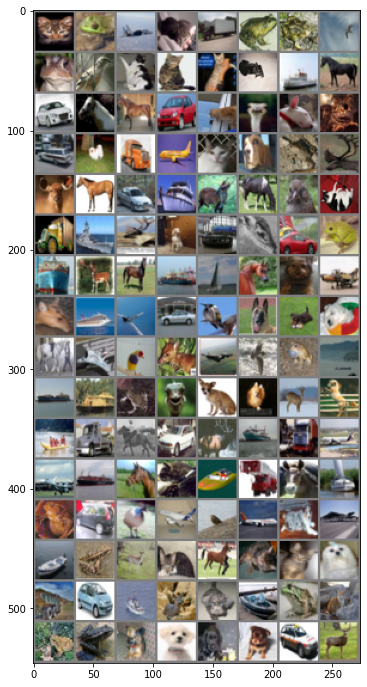

In [11]:
images, labels = next(iter(trainloader))

plt.figure(figsize=(12,12))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid)

In [39]:
class ModelBaseline(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(2704, 128),
            nn.ReLU()
        )
        self.prediction = nn.Sequential(
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.vgg(x)
        x = self.fc(x)
        x = self.prediction(x)
        return x

In [52]:
class CifarBaseline(pl.LightningModule):
    def __init__(self, lr=1e-02):
        super().__init__()
        self.save_hyperparameters()
        self.model = ModelBaseline()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        output = self(imgs)
        loss = nn.CrossEntropyLoss()(output, labels)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        imgs, labels = batch
        output = self(imgs)
        loss = nn.CrossEntropyLoss()(output, labels)
        preds = torch.argmax(output, dim=1)
        acc = accuracy(output, labels)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                total_steps=50000
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


In [53]:
model = CifarBaseline()

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None, 
    logger=CSVLogger(save_dir="./"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, trainloader, testloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type          | Params
----------------------------------------
0 | model | ModelBaseline | 354 K 
----------------------------------------
354 K     Trainable params
0         Non-trainable params
354 K     Total params
1.418     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
